# Machine Intelligence 1

$\Large{Group: ALT}$  

## Validation and Regularization
### Cross Validation

In [1]:
import math
import numpy as np
import itertools
from tabulate import tabulate
import matplotlib.pyplot as plt
import time
import random
from numpy import linalg as LA
#plt.style.use('dark_background')


In [2]:
#Import training set
training_set = np.genfromtxt(fname='TrainingRidge.csv', delimiter=',', 
                       dtype=np.float, skip_header=1)
x_training = training_set[:,:2]
y_training = training_set[:,-1]



In [3]:
#import validation set
validation_set = np.genfromtxt(fname='ValidationRidge.csv', delimiter=',', 
                       dtype=np.float, skip_header=1)
x_validation = validation_set[:,:2]
y_validation = validation_set[:,-1]


__a) Preprocessing__


$\mathbf{x}^{(\alpha)}{centered} = \mathbf{x}^{(\alpha)} - \langle \mathbf{x} \rangle$ with $\langle \mathbf{x} \rangle = \frac{1}{p}\sum^p{\alpha = 1} \mathbf{x}^{(\alpha)}$

In [4]:
xtraining_mean = np.mean(x_training, axis=0)
xtraining_mean

array([176.33,  78.5 ])

In [5]:
xt_centered = x_training-xtraining_mean #x training centered

$\mathbf{C} = \frac{1}{p} \sum^p_{\alpha = 1} x^{(\alpha)}{centered} x^{(\alpha)^{T}}{centered} = \frac{1}{p} \mathbf{X}{centered} \mathbf{X}{centered}^T$

In [6]:
cov_matrix = np.cov(xt_centered, rowvar = False, bias = True)

In [7]:
cov_matrix

array([[394.7111,  22.535 ],
       [ 22.535 , 541.47  ]])

In [8]:
#compute eigenvectors and eigenvalues
eigen_vals, eigen_vecs = LA.eig(cov_matrix)
print("Eigen values: ",eigen_vals,"\nEigen vectors:\n",eigen_vecs)

Eigen values:  [391.32877626 544.85232374] 
Eigen vectors:
 [[-0.988923   -0.14842945]
 [ 0.14842945 -0.988923  ]]


In [9]:
Lambda_power = (LA.inv(np.diag(eigen_vals)))**(0.5)
print(Lambda_power)

[[0.05055093 0.        ]
 [0.         0.0428411 ]]


$\mathbf{x}^{(\alpha){sphered}} = \mathbf{\Lambda}^{-\frac{1}{2}} \mathbf{E}^T \mathbf{x}^{(\alpha){centered}}$

In [10]:
#x training set sphered
xt_sphered = np.dot(np.dot(Lambda_power,eigen_vecs.T),xt_centered.T)

In [11]:
#Examining the properties of the data after sphering:
print("Mean: ",np.mean(xt_sphered),"\nVariance: ",
            np.var(xt_sphered),"\nCovariance :\n",
            np.cov(xt_sphered, bias = True))

Mean:  3.419486915845482e-16 
Variance:  1.0000000000000002 
Covariance :
 [[1.00000000e+00 3.10862447e-17]
 [3.10862447e-17 1.00000000e+00]]


We can see that the training data after sphering has a mean that is approximately zero, variance equal to one and covariance $C_{ij}$ $\approx$ 0 , meaning that the sphering was correctly performed .

In [12]:
#sphering in the validation set
xv_centered = x_validation-xtraining_mean #centering of the validation data
xv_sphered = np.dot(np.dot(Lambda_power,eigen_vecs.T),xv_centered.T) #sphering of the validation data

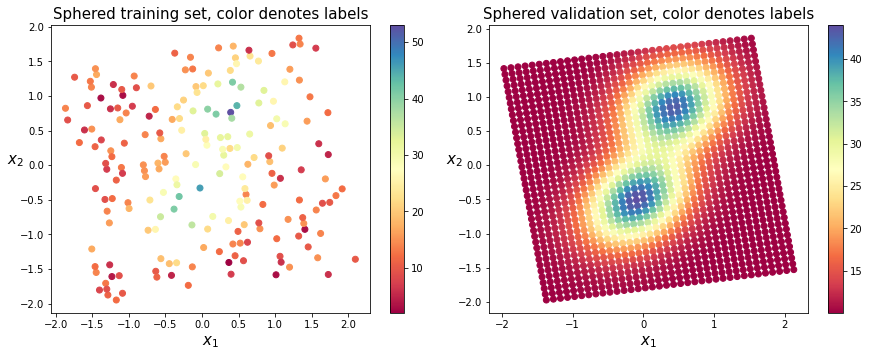

In [13]:
plt.figure(figsize=(15, 8))

plt.subplot(121)
plt.scatter(xt_sphered[0],xt_sphered[1], c=y_training, cmap="Spectral")
plt.xlabel("$x_1$", fontsize = 15)
plt.ylabel("$x_2$", rotation = "horizontal", fontsize = 15)
plt.title("Sphered training set, color denotes labels", fontsize = 15)
plt.colorbar()

plt.subplot(122)
plt.scatter(xv_sphered[0],xv_sphered[1],c=y_validation, cmap="Spectral")
plt.xlabel("$x_1$", fontsize = 15)
plt.ylabel("$x_2$", rotation = "horizontal",fontsize = 15)
plt.title("Sphered validation set, color denotes labels", fontsize = 15)
plt.colorbar()

plt.subplots_adjust(bottom=0.25, top=0.75,wspace = 0.1)
plt.show()

__b) expand the sphered 2D input to all possible monomials up to degree 9.__

In [14]:
def calculate_phi(i,x,y):
    i = i-1
    comb_powers = np.array( [p for p in itertools.product(range(10), repeat=2)])
    comb_powers = comb_powers[comb_powers[:,0]+comb_powers[:,1] <= 9]
    monomial = x**comb_powers[i,0]*y**comb_powers[i,1]
    return [monomial,comb_powers[i,:]]


__(i) First 10 monomials__

In [15]:
Phi_10 = np.array([calculate_phi(j,xv_sphered[0],xv_sphered[1])[0] for j in range(1,11)])
powers = np.array([calculate_phi(j,xv_sphered[0],xv_sphered[1])[1] for j in range(1,11)])
Phi_10.shape

(10, 1476)

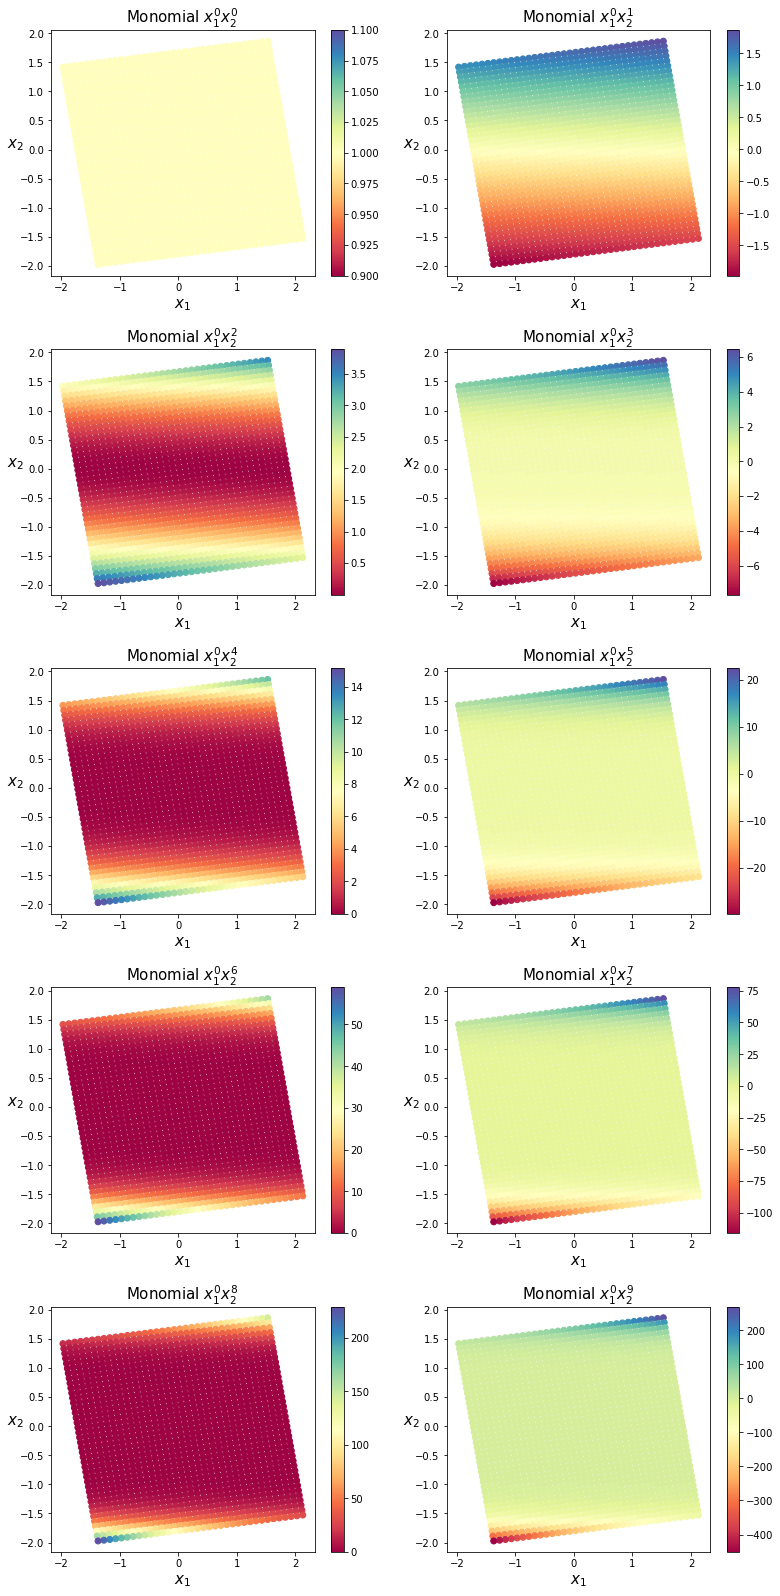

In [16]:
fig = plt.figure(figsize=(13,28))
for i in np.arange(10):
    ax1 = fig.add_subplot(5,2,i+1)
    plt.scatter(xv_sphered[0],xv_sphered[1], c=Phi_10[i],cmap="Spectral")
    plt.xlabel("$x_1$", fontsize = 15)
    plt.ylabel("$x_2$", rotation = "horizontal", fontsize = 15)
    plt.title("Monomial $x_1^{}$".format(powers[i][0])+"$x_2^{}$ ".format(powers[i][1]), fontsize = 15)
    plt.colorbar()
plt.subplots_adjust(hspace = 0.3)   
plt.show()

__(ii) y(x;w) predicted function__

In [17]:
def regularization(Lambda_r,phi_r,yT_r):
    temp = LA.inv(np.dot(phi_r,phi_r.T)+Lambda_r*np.eye(phi_r.shape[0]))
    opt_w = np.dot(np.dot(temp,phi_r),yT_r)
    return opt_w

$\mathbf{w}^{*} = (\mathbf{\Phi \Phi^T})^{-1} \mathbf{\Phi \; y}_T^T$

In [18]:
# on the training set
Phi_training = np.array([calculate_phi(j,xt_sphered[0],xt_sphered[1])[0] for j in range(1,56)])
optimal_w = regularization(0,Phi_training,y_training)
yt_predicted = np.dot(optimal_w.T,Phi_training) 
Phi_training.shape

(55, 200)

In [19]:
# on the validation set
Phi_val = np.array([calculate_phi(j,xv_sphered[0],xv_sphered[1])[0] for j in range(1,56)])
Phi_val.shape

(55, 1476)

In [20]:
yv_predicted = np.dot(optimal_w.T,Phi_val) #for the validation set

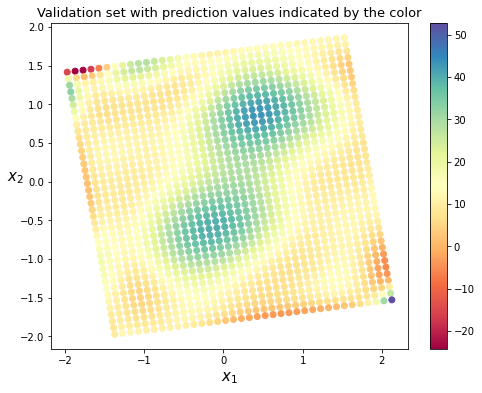

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(xv_sphered[0],xv_sphered[1], c=yv_predicted, cmap="Spectral")
plt.xlabel("$x_1$", fontsize = 15)
plt.ylabel("$x_2$", rotation = "horizontal", fontsize = 15)
plt.title("Validation set with prediction values indicated by the color", fontsize = 13)
plt.colorbar()
plt.show()

__c) Regularization__

In [22]:
def MSE(A,B):
    mse = np.mean((A - B)**2)
    return mse

In [23]:
def folds(yT,x_tr,lambdaf):
    x_tr = x_tr.T
    size_fold = int(len(x_tr)/10)
    mse_folds = np.zeros(10)
    for j in range(10):
        test_set = x_tr[j*size_fold:j*size_fold+size_fold]
        ytest_set = yT[j*size_fold:j*size_fold+size_fold]
        
        training_set = np.delete(x_tr,np.arange(j*size_fold,j*size_fold+size_fold),axis=0)
        ytraining_set = np.delete(yT,np.arange(j*size_fold,j*size_fold+size_fold),axis=0)
        
        Phi_fold_training = np.array([calculate_phi(idx,training_set.T[0],training_set.T[1])[0] for idx in range(1,56)])
        weight_fold = regularization(lambdaf,Phi_fold_training,ytraining_set)
        
        
        Phi_fold_test = np.array([calculate_phi(idx,test_set.T[0],test_set.T[1])[0] for idx in range(1,56)])
        y_test_predicted = np.dot(weight_fold.T,Phi_fold_test)
        
        
        mse_folds[j] = MSE(ytest_set,y_test_predicted)
    
    mean = np.mean(mse_folds)
    std = np.std(mse_folds)
    return [mean,std]
        

In [24]:
def cross_validation(yT,x_tr):
    powers_lambda = np.arange(-4,4.1,0.1)
    Lambdas = 10**powers_lambda
    mse_means = np.zeros(len(Lambdas))
    mse_std = np.zeros(len(Lambdas))
    for i in range(len(Lambdas)):
        lambdai = Lambdas[i]
        [mse_means[i],mse_std[i]]= folds(yT,x_tr,Lambdas[i])
    return [mse_means,mse_std,Lambdas]

        

In [25]:
[mse_means_t,mse_std_t,Lambda_t] = cross_validation(y_training,xt_sphered)

__(i) Plot the average and standard deviation of the MSE (mean squared error, i.e., average quadratic cost of the predictions) over the testset for all folds against λ (as an error-barplot with a logarithmic x-axis for λ).__

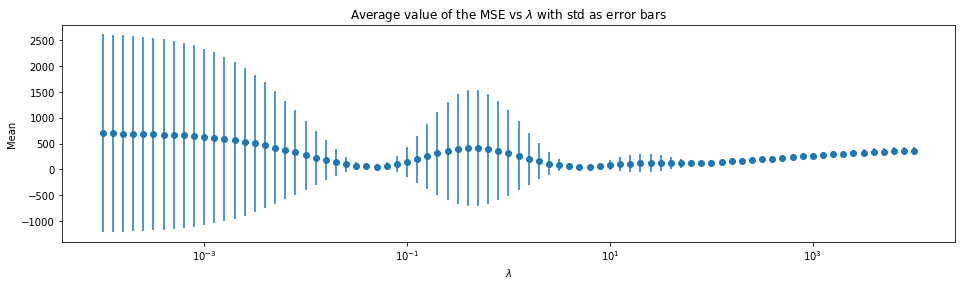

In [26]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(111)
ax.errorbar(Lambda_t,mse_means_t,yerr=mse_std_t,fmt='o')
ax.set_xscale('log')
ax.set_xlabel("$\lambda$")
ax.set_ylabel("Mean")
ax.set_title("Average value of the MSE vs $\lambda$ with std as error bars")
plt.show()

__ii)  Idenitfy  the  value  of  the  best  regularization  coefficient $\lambda^{*}_T$,  which  has  the  minimal average MSE over all test folds.__

In [27]:
best_Lamb = Lambda_t[np.argmin(mse_means_t)]
best_Lamb

5.011872336272776

__iii)  Train the model using the entire original training set regularized by λ∗T.  Plot the true labels of the validation set alongside your model’s predictions.  What is the MSE of the model on the validation set?__

In [28]:
w_optimal_lamb = regularization(best_Lamb,Phi_training,y_training)

In [29]:
yv_w_optimal_lamb = np.dot(w_optimal_lamb.T,Phi_val)

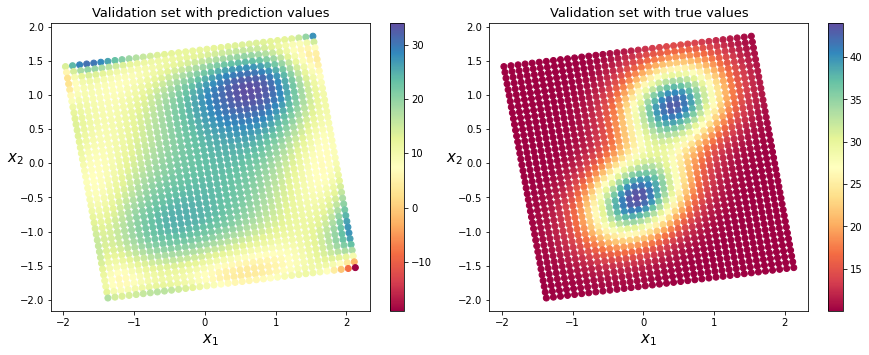

In [30]:
plt.figure(figsize=(15, 8))

plt.subplot(121)
plt.scatter(xv_sphered[0],xv_sphered[1], c=yv_w_optimal_lamb, cmap="Spectral")
plt.xlabel("$x_1$", fontsize = 15)
plt.ylabel("$x_2$", rotation = "horizontal", fontsize = 15)
plt.title("Validation set with prediction values", fontsize = 13)
plt.colorbar()

plt.subplot(122)
plt.scatter(xv_sphered[0],xv_sphered[1], c=y_validation, cmap="Spectral")
plt.xlabel("$x_1$", fontsize = 15)
plt.ylabel("$x_2$", rotation = "horizontal", fontsize = 15)
plt.title("Validation set with true values", fontsize = 13)
plt.colorbar()

plt.subplots_adjust(bottom=0.25, top=0.75,wspace = 0.1)
plt.show()

In [31]:
print("The MSE of the model on the validation set is: ",MSE(yv_w_optimal_lamb,y_validation))

The MSE of the model on the validation set is:  24.675851287829843


__d)Compare these empirical estimates of bias and variance with the true generalization error.__

In [32]:
[mse_means_v,mse_std_v,Lambda_v] = cross_validation(y_validation,xv_sphered)

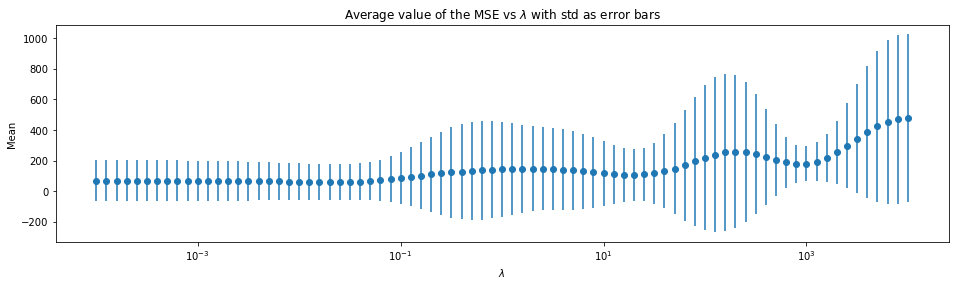

The best regularization coefficient is:  0.01995262314968889


In [33]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(111)
ax.errorbar(Lambda_v,mse_means_v,yerr=mse_std_v,fmt='o')
ax.set_xscale('log')
ax.set_xlabel("$\lambda$")
ax.set_ylabel("Mean")
ax.set_title("Average value of the MSE vs $\lambda$ with std as error bars")
plt.show()
best_Lamb_v = Lambda_v[np.argmin(mse_means_v)]
print("The best regularization coefficient is: ",best_Lamb_v)

In [34]:
w_optimal_lamb_v = regularization(best_Lamb_v,Phi_val,y_validation)

In [35]:
yv_validation_lamb = np.dot(w_optimal_lamb_v.T,Phi_val)

In [36]:
print("The MSE of the model on the validation set is: ",MSE(yv_validation_lamb,y_validation))

The MSE of the model on the validation set is:  1.701775556105077


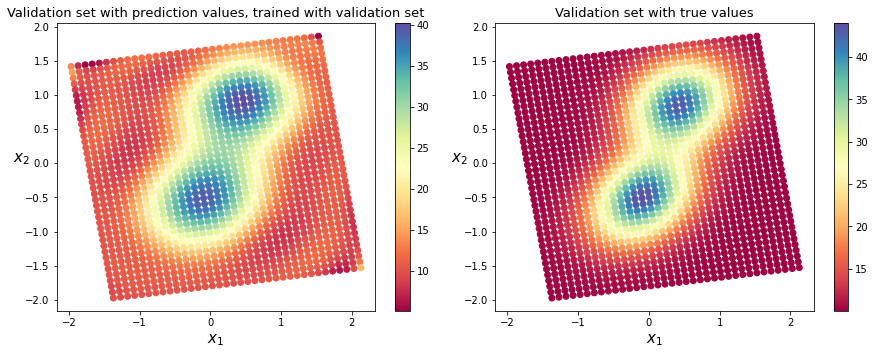

In [37]:
plt.figure(figsize=(15, 8))

plt.subplot(121)
plt.scatter(xv_sphered[0],xv_sphered[1], c=yv_validation_lamb, cmap="Spectral")
plt.xlabel("$x_1$", fontsize = 15)
plt.ylabel("$x_2$", rotation = "horizontal", fontsize = 15)
plt.title("Validation set with prediction values, trained with validation set", fontsize = 13)
plt.colorbar()

plt.subplot(122)
plt.scatter(xv_sphered[0],xv_sphered[1], c=y_validation, cmap="Spectral")
plt.xlabel("$x_1$", fontsize = 15)
plt.ylabel("$x_2$", rotation = "horizontal", fontsize = 15)
plt.title("Validation set with true values", fontsize = 13)
plt.colorbar()

plt.subplots_adjust(bottom=0.25, top=0.75,wspace = 0.1)
plt.show()

__e)  Is $\lambda^*_G$ different from $\lambda^*_T$?__

In [38]:
print("Lambda* G is ",best_Lamb_v, "\nLambda* T is ", best_Lamb)

Lambda* G is  0.01995262314968889 
Lambda* T is  5.011872336272776


Yes,  $\lambda^*_G$ different from $\lambda^*_T$.

__(i) Plot the function learned in (c) using λ∗T with the function that is learned in (d) using λ∗G on the original training set.__

In [39]:
yt_learn_training = np.dot(w_optimal_lamb.T,Phi_training)
yt_learn_validation = np.dot(w_optimal_lamb_v.T,Phi_training)


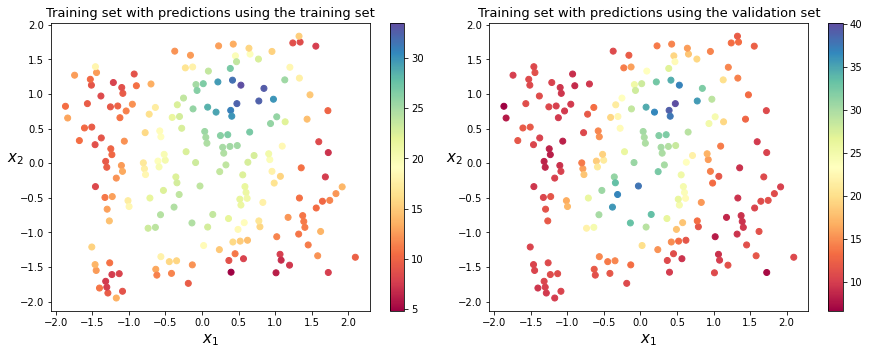

In [40]:
plt.figure(figsize=(15, 8))

plt.subplot(121)
plt.scatter(xt_sphered[0],xt_sphered[1], c=yt_learn_training, cmap="Spectral")
plt.xlabel("$x_1$", fontsize = 15)
plt.ylabel("$x_2$", rotation = "horizontal", fontsize = 15)
plt.title("Training set with predictions using the training set", fontsize = 13)
plt.colorbar()

plt.subplot(122)
plt.scatter(xt_sphered[0],xt_sphered[1], c=yt_learn_validation, cmap="Spectral")
plt.xlabel("$x_1$", fontsize = 15)
plt.ylabel("$x_2$", rotation = "horizontal", fontsize = 15)
plt.title("Training set with predictions using the validation set", fontsize = 13)
plt.colorbar()

plt.subplots_adjust(bottom=0.25, top=0.75,wspace = 0.1)
plt.show()

In [41]:
yv_learn_training = np.dot(w_optimal_lamb.T,Phi_val)
yv_learn_validation = np.dot(w_optimal_lamb_v.T,Phi_val)


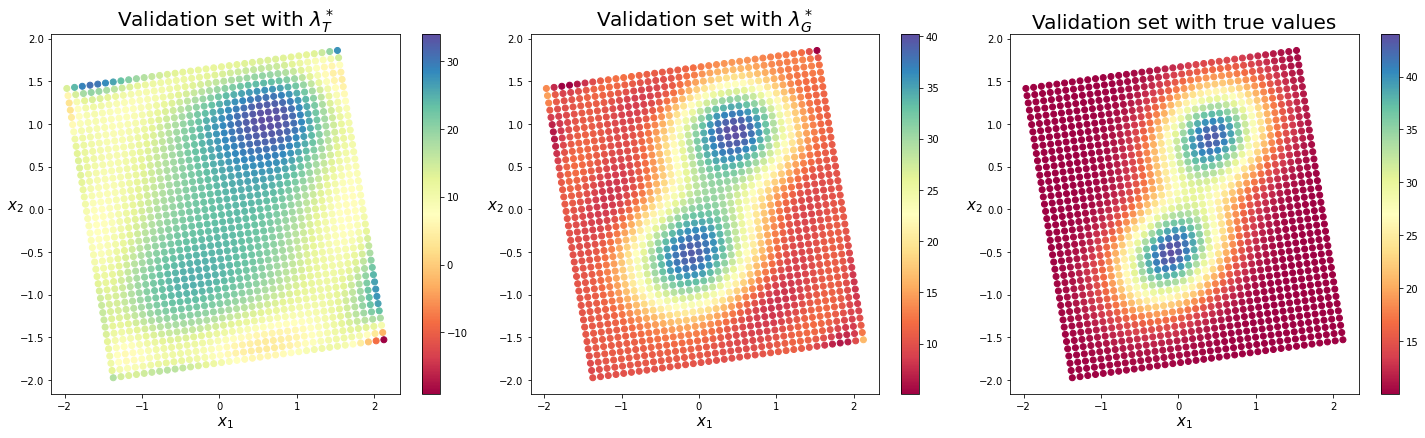

In [42]:
plt.figure(figsize=(25, 10))

plt.subplot(131)
plt.scatter(xv_sphered[0],xv_sphered[1], c=yv_learn_training, cmap="Spectral")
plt.xlabel("$x_1$", fontsize = 15)
plt.ylabel("$x_2$", rotation = "horizontal", fontsize = 15)
plt.title("Validation set with $\lambda^*_T$", fontsize = 20)
plt.colorbar()

plt.subplot(132)
plt.scatter(xv_sphered[0],xv_sphered[1], c=yv_learn_validation, cmap="Spectral")
plt.xlabel("$x_1$", fontsize = 15)
plt.ylabel("$x_2$", rotation = "horizontal", fontsize = 15)
plt.title("Validation set with $\lambda^*_G$", fontsize = 20)
plt.colorbar()

plt.subplot(133)
plt.scatter(xv_sphered[0],xv_sphered[1], c=y_validation, cmap="Spectral")
plt.xlabel("$x_1$", fontsize = 15)
plt.ylabel("$x_2$", rotation = "horizontal", fontsize = 15)
plt.title("Validation set with true values", fontsize = 20)
plt.colorbar()

plt.subplots_adjust(bottom=0.25, top=0.75,wspace = 0.1)
plt.show()

The $\lambda^*_G$ is obtained by training on the validation set, so it makes sense that the predicted values are closer to the ground truth. 
By comparing $\lambda^*_T$ to $\lambda^*_G$ we could also assume that our model trained with the training set might have overfitted the data.
